In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()

DATA_CLEAN = PROJECT_ROOT / "output" / "clean" / "all_airlines_lax_clean.csv"
IMAGES_DIR = PROJECT_ROOT / "images"
IMAGES_DIR.mkdir(parents=True, exist_ok=True)


Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv(DATA_CLEAN, parse_dates=["date"])
df = df.sort_values("date").set_index("date")

# Prophet expects columns 'ds' (date) and 'y' (target)
df_prophet = df[["pax_total"]].rename(columns={"pax_total": "y"})
df_prophet["ds"] = df_prophet.index

df_prophet.head()


,y,ds
date,,
2002-10-01,2140300.0,2002-10-01
2002-11-01,2056282.0,2002-11-01
2002-12-01,2333768.0,2002-12-01
2003-01-01,2097734.0,2003-01-01
2003-02-01,1842343.0,2003-02-01


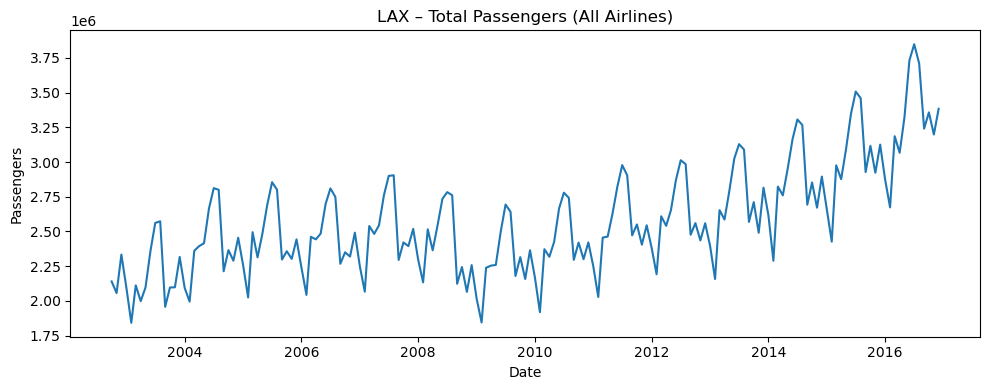

In [3]:
plt.figure(figsize=(10,4))
plt.plot(df_prophet["ds"], df_prophet["y"])
plt.title("LAX – Total Passengers (All Airlines)")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.tight_layout()
plt.show()


In [4]:
horizon = 24  # months

train = df_prophet.iloc[:-horizon]
test = df_prophet.iloc[-horizon:]

print(train["ds"].min(), "→", train["ds"].max(), " (train)")
print(test["ds"].min(), "→", test["ds"].max(), " (test)")


2002-10-01 00:00:00 → 2014-12-01 00:00:00  (train)
2015-01-01 00:00:00 → 2016-12-01 00:00:00  (test)


In [5]:
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)
m.fit(train)


15:02:27 - cmdstanpy - INFO - Chain [1] start processing
15:02:27 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# Make a dataframe covering entire history
history_periods = len(df_prophet)
future = m.make_future_dataframe(periods=horizon, freq="MS")  # MS = month start
forecast = m.predict(future)

forecast.tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
166,2016-08-01,3.084466e+06,3.336566e+06,3.516209e+06,3.037136e+06,3.134063e+06,339140.423867,339140.423867,339140.423867,339140.423867,339140.423867,339140.423867,0.0,0.0,0.0,3.423606e+06
167,2016-09-01,3.093653e+06,2.810338e+06,2.993070e+06,3.042642e+06,3.147482e+06,-191114.238016,-191114.238016,-191114.238016,-191114.238016,-191114.238016,-191114.238016,0.0,0.0,0.0,2.902539e+06
168,2016-10-01,3.102545e+06,2.949207e+06,3.139714e+06,3.047649e+06,3.159559e+06,-58896.420256,-58896.420256,-58896.420256,-58896.420256,-58896.420256,-58896.420256,0.0,0.0,0.0,3.043648e+06
169,2016-11-01,3.111732e+06,2.826417e+06,3.011747e+06,3.053102e+06,3.173618e+06,-196567.702468,-196567.702468,-196567.702468,-196567.702468,-196567.702468,-196567.702468,0.0,0.0,0.0,2.915165e+06
170,2016-12-01,3.120624e+06,3.013286e+06,3.220471e+06,3.057652e+06,3.188382e+06,-6114.669941,-6114.669941,-6114.669941,-6114.669941,-6114.669941,-6114.669941,0.0,0.0,0.0,3.114509e+06


In [8]:
# Align forecast with test dates
fc_test = forecast.set_index("ds").loc[test["ds"]]

y_true = test["y"].values
y_pred = fc_test["yhat"].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # FIXED
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"LAX – Prophet baseline")
print(f"MAE : {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"MAPE: {mape:,.2f}%")


LAX – Prophet baseline
MAE : 175,934
RMSE: 209,874
MAPE: 5.31%


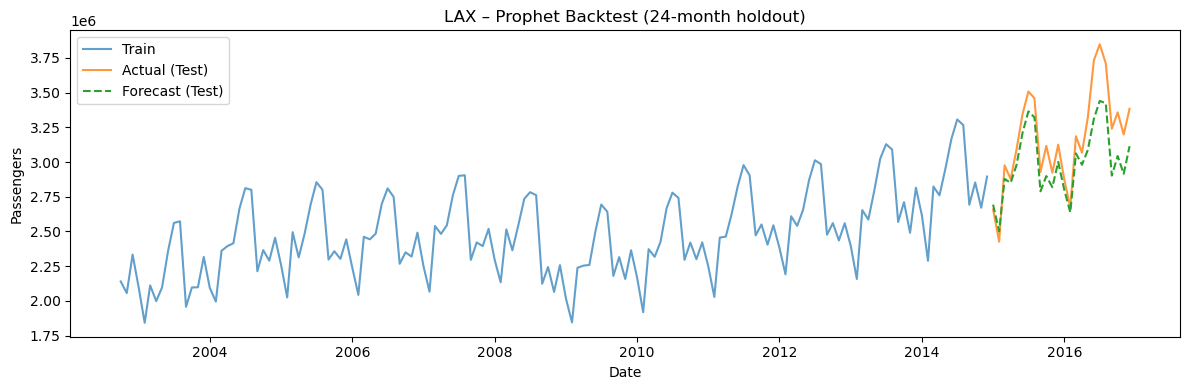

Saved backtest plot to: c:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_D_LAX_Airport_Growth_Prediction\images\lax_prophet_backtest_24m.png


In [9]:
# 7) Backtest visual

plt.figure(figsize=(12,4))

plt.plot(train["ds"], train["y"], label="Train", alpha=0.7)
plt.plot(test["ds"], test["y"], label="Actual (Test)", alpha=0.8)
plt.plot(fc_test.index, fc_test["yhat"], label="Forecast (Test)", linestyle="--")

plt.title("LAX – Prophet Backtest (24-month holdout)")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.tight_layout()

backtest_path = IMAGES_DIR / "lax_prophet_backtest_24m.png"
plt.savefig(backtest_path, dpi=150)
plt.show()

print("Saved backtest plot to:", backtest_path)


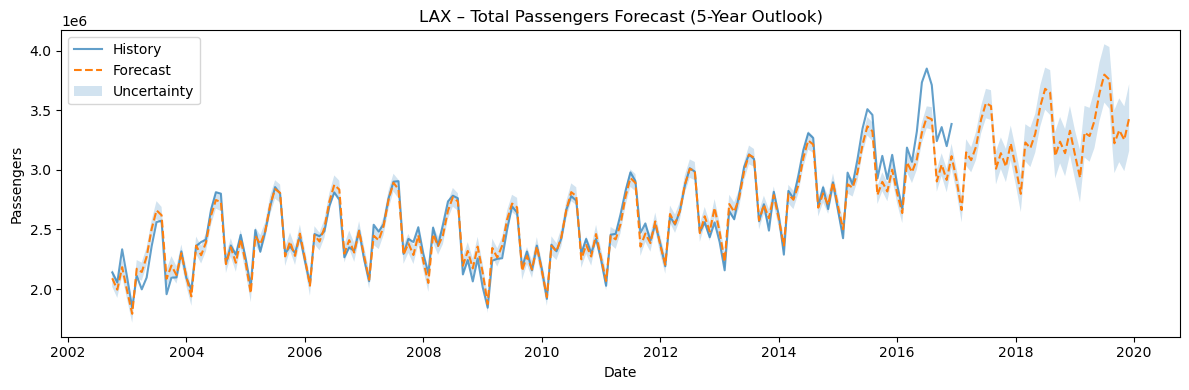

Saved forecast plot to: c:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_D_LAX_Airport_Growth_Prediction\images\lax_prophet_forecast_5y.png


In [10]:
# 8) 5-year future forecast

future_horizon = 12 * 5  # 5 years
future_full = m.make_future_dataframe(periods=future_horizon, freq="MS")
forecast_full = m.predict(future_full)

plt.figure(figsize=(12,4))
plt.plot(df_prophet["ds"], df_prophet["y"], label="History", alpha=0.7)
plt.plot(forecast_full["ds"], forecast_full["yhat"], label="Forecast", linestyle="--")

# Uncertainty interval
plt.fill_between(
    forecast_full["ds"],
    forecast_full["yhat_lower"],
    forecast_full["yhat_upper"],
    alpha=0.2,
    label="Uncertainty"
)

plt.title("LAX – Total Passengers Forecast (5-Year Outlook)")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.tight_layout()

forecast_path = IMAGES_DIR / "lax_prophet_forecast_5y.png"
plt.savefig(forecast_path, dpi=150)
plt.show()

print("Saved forecast plot to:", forecast_path)


c:\Users\Seb\anaconda3\envs\aviation\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Seb\anaconda3\envs\aviation\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Seb\anaconda3\envs\aviation\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. 

Saved components plot to: c:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_D_LAX_Airport_Growth_Prediction\images\lax_prophet_components.png


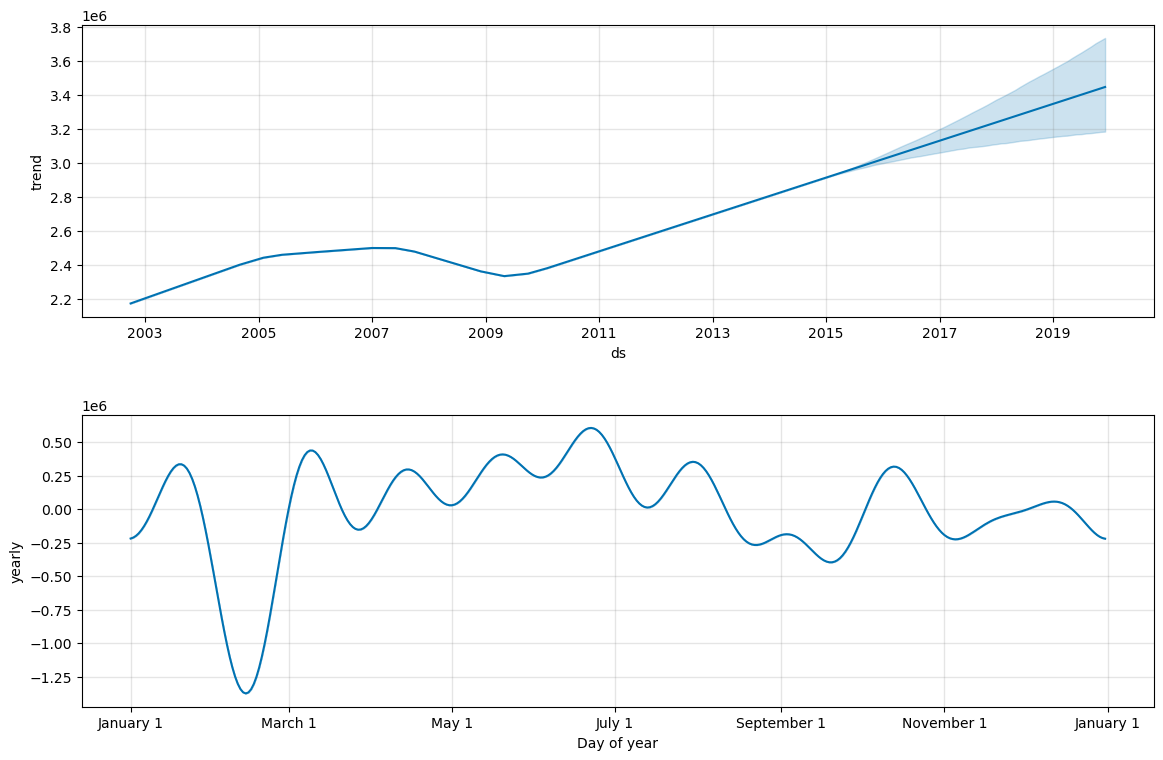

In [11]:
# 9) Seasonality analysis

fig = m.plot_components(forecast_full)
fig.set_size_inches(12, 8)  # make it a bit larger

components_path = IMAGES_DIR / "lax_prophet_components.png"
fig.savefig(components_path, dpi=150, bbox_inches="tight")

print("Saved components plot to:", components_path)


In [12]:
# 10) Yearly growth summary from forecast_full

fc = forecast_full.copy()
fc["year"] = fc["ds"].dt.year

yearly = (
    fc.groupby("year")["yhat"]
    .sum()
    .rename("pax_forecast")
    .to_frame()
)

yearly["pax_forecast_millions"] = yearly["pax_forecast"] / 1e6
yearly["yoy_growth_%"] = yearly["pax_forecast"].pct_change() * 100

yearly.tail(10)


,pax_forecast,pax_forecast_millions,yoy_growth_%
year,,,
2010,2.881703e+07,28.817025,3.176738
2011,3.011273e+07,30.112730,4.496319
2012,3.152529e+07,31.525294,4.690920
2013,3.271456e+07,32.714558,3.772409
2014,3.401144e+07,34.011441,3.964240
2015,3.530857e+07,35.308568,3.813797
2016,3.672135e+07,36.721354,4.001254
2017,3.791064e+07,37.910644,3.238688
2018,3.920753e+07,39.207527,3.420896
